**MSM analysis on colab**

In [ ]:
!nvidia-smi

Sat Mar 27 05:38:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



**Import the required libraries**



In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm


!pip install pyemma
!pip install threadpoolctl

import pyemma

     |████████████████████████████████| 1.6MB 14.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.7MB/s 
  Using cached https://files.pythonhosted.org/packages/af/da/271e93bb98bc93ccac17bc1f31f814be4f9e7024ac19bf31af892a462030/mdtraj-1.9.5-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 327kB 39.8MB/s 
Processing /root/.cache/pip/wheels/35/53/59/f40630becd10a799470093cd5209fcc4351da6a15650eadc3d/deeptime-0.2.6-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 604kB 29.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for pyemma: filename=pyEMMA-2.5.9-cp37-cp37m-linux_x86_64.whl size=2497971 sha256=1a6f5adab279fd88dbf89cd65739a61a02bd649e3aaba37ca945e3e61f6138b4
  

**Mount the google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the encoded dataset**

In [3]:
latent = torch.load('/content/drive/MyDrive/DNN_TAE/latent_dnn_tae.pt',map_location='cpu')
latent = np.array(latent.detach())

In [ ]:
#cluster_kmeans = pickle.load(open('/content/drive/MyDrive/Autoencoding/cluster_kmeans_ae.pkl','rb'))

In [ ]:
#pickle.dump(cluster_kmeans,open('cluster_1000.pkl','wb'))

In [5]:
np.shape(latent)

(4022018, 2)

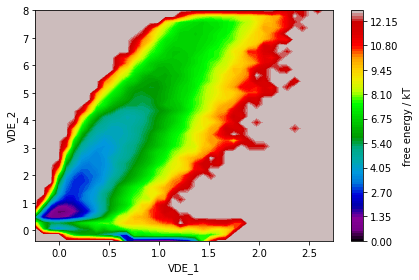

In [4]:
fig, ax, misc =pyemma.plots.plot_free_energy(*latent.T,nbins=40,
                                             legacy=False,avoid_zero_count=True)
ax.set_xlabel('VDE_1')
ax.set_ylabel('VDE_2')
fig.tight_layout()
plt.savefig('VDE_fes_not_sampled.png' ,dpi=300)

In [6]:
%%time
cluster_kmeans = pyemma.coordinates.cluster_kmeans(latent, max_iter=1500, k=1500)

CPU times: user 7h 4min 4s, sys: 9.66 s, total: 7h 4min 13s
Wall time: 1h 47min 19s


In [7]:
cluster_kmeans.dtrajs

[array([679, 799, 799, ..., 984, 478, 444], dtype=int32)]

In [8]:
lags=[2,10,20,40,60,80,110, 140, 170, 200, 240]
its =pyemma.msm.its(cluster_kmeans.dtrajs,lags=lags, nits =10)

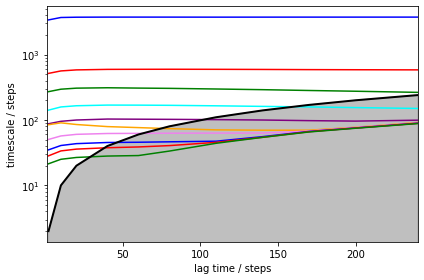

In [9]:
fig = pyemma.plots.plot_implied_timescales(its,nits=10, ylog=True)
#plt.xlim(2,100)
plt.tight_layout()
plt.savefig('its_tae_1.png', dpi =300)

In [10]:
msm = pyemma.msm.estimate_markov_model(cluster_kmeans.dtrajs, lag=75)

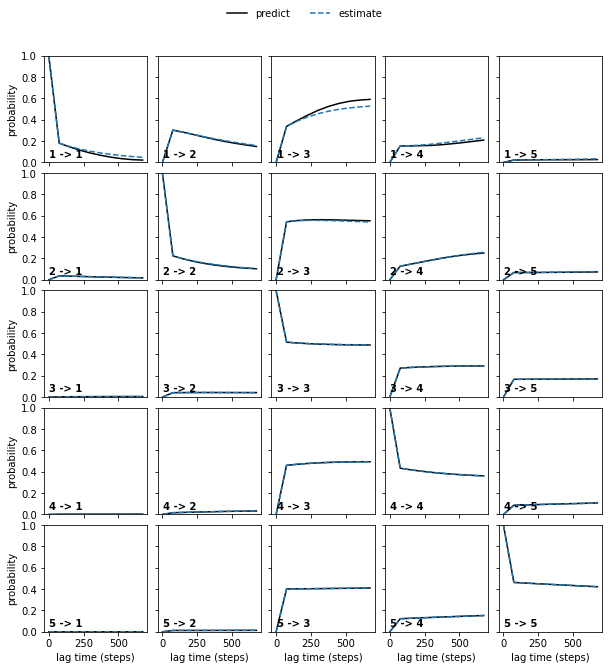

In [11]:
fig=pyemma.plots.plot_cktest(msm.cktest(5))

plt.savefig('cktest_6.png', dpi = 300)

In [12]:
print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


In [13]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[3.39228979e-02 2.53857014e-04 1.14024777e-03 ... 6.36507749e-05
 1.21483889e-03 5.46999484e-05]
sum of weights = 1.000000


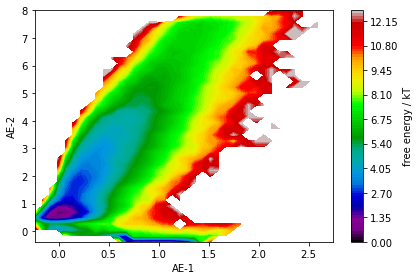

In [14]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    *latent.T,nbins=40,
    weights=np.concatenate(msm.trajectory_weights()),
    legacy=False)
ax.set_xlabel('AE-1')
ax.set_ylabel('AE-2')
#ax.set_xlim(-4, 4)
#ax.set_ylim(-4, 4)
#ax.set_aspect('equal')
fig.tight_layout()
plt.savefig('reweighted_fes_ae.png',dpi =300)

In [15]:
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.003674
π_2 = 0.017243
π_3 = 0.226086
π_4 = 0.347856
π_5 = 0.405141


In [16]:
nstates=5
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / steps:


,1,2,3,4,5
1,0.00,4358.69,535.02,1789.95,9680.82
2,55615.94,0.00,356.35,1626.03,9638.69
3,70214.99,14825.60,0.00,992.70,9224.55
4,72582.96,17499.79,1002.72,0.00,8967.66
5,78015.03,23082.09,5361.07,6482.86,0.00


In [17]:
msm.dtrajs_active

[array([679, 799, 799, ..., 984, 478, 444])]

In [18]:
metastable_traj = msm.metastable_assignments[tuple(msm.dtrajs_active)]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster_kmeans.clustercenters[msm.active_set[highest_membership]]

In [19]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

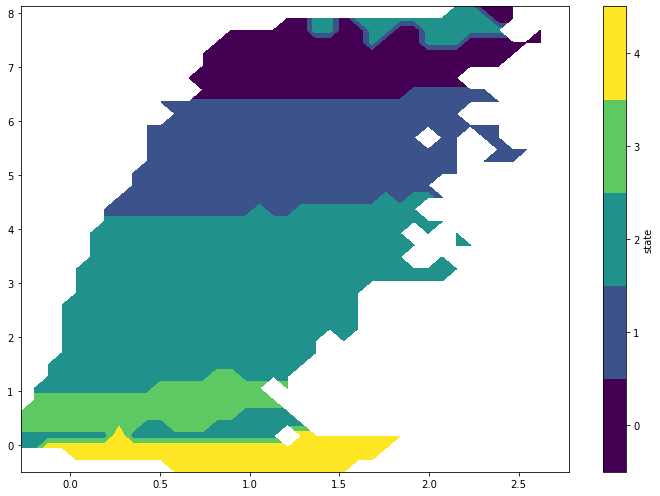

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *latent.T, metastable_traj,nbins=40, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(0, nstates+1))  # set state numbers 1 ... nstates

# pyemma.plots.plot_network(
#      inverse_mfpt,
# # #    pos=coarse_state_centers,
#      pos = np.array([[0.95,0.4],
#                      [0.85, 0.70],
#                      [0.6 , 0.9],
#                     [0.2 , 0.6]]),
# #     xpos=np.array([0.8791888,0.7490787,0.80000,0.50973363]),
#      state_scale=0.4,
# #     #arrow_scale=1.0,
#      arrow_curvature=0.5,
# #     figpadding=None,
#      arrow_label_format='%.1f ps',
#      arrow_labels=mfpt,
#      size=12,
#      show_frame=True,
#      ax=ax)

#ax.set_xlabel('$\Phi$')
#ax.set_ylabel('$\Psi$')
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
fig.tight_layout()
plt.savefig('Ae_4_state_1000cls.png',dpi=300)

In [26]:
unscaled = np.load('/content/drive/MyDrive/Autoencoding/Unscaled_data_sorted.npy')

In [27]:
#unscaled = unscaled[np.where(unscaled[:,0] <1.8)]

In [28]:
np.max(unscaled,axis=0)

array([ 3.968, 42.   ])

In [29]:
state0=unscaled[metastable_traj==0]
state1=unscaled[metastable_traj==1]
state2=unscaled[metastable_traj==2]
state3=unscaled[metastable_traj==3]
state4=unscaled[metastable_traj==4]

In [30]:
print(np.mean(state0,axis=0))
print(np.mean(state1,axis=0))
print(np.mean(state2,axis=0))
print(np.mean(state3,axis=0))
print(np.mean(state4,axis=0))

[ 1.90795919 24.71979695]
[ 1.83124206 23.34831509]
[ 1.73123754 22.99904763]
[ 1.57296468 21.52824229]
[ 1.28606836 14.98386576]


In [ ]:
pickle.dump(cluster_kmeans,open('cluster_kmeans_1500_tae.pkl','wb'))